In [145]:
from utils.bigquery_handler import BigQueryHandler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import math

In [146]:
bqh = BigQueryHandler('unir-predictiv0-andina-espana')

query = f"""
    SELECT 
        fecha, 
        anio, 
        mes, 
        tipo_movimiento_cod, 
        cod_pais, 
        cod_provincia, 
        cod_comunidad, 
        cod_taric, 
        dolares, 
        kilogramos
    FROM `unir-predictiv0-andina-espana.datacomex.comex_comunidad_andina_modelo` 
    WHERE nivel_taric = '1' AND tipo_movimiento_cod = 'I' AND cod_taric = '89'
"""

data = bqh.get_bigquery_data(query)

In [147]:
df = data.copy()
df.dropna(inplace=True)

df['fecha'] = pd.to_datetime(df['fecha'])
df = df.sort_values(by='fecha').reset_index(drop=True)

df['month_sin'] = np.sin(2 * np.pi * df['mes'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['mes'] / 12)

In [148]:
categorical_features = [
    'tipo_movimiento_cod', 
    'cod_pais', 
    'cod_provincia', 
    'cod_comunidad', 
    'cod_taric'
]

               
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

feature_columns = df.columns.drop(['fecha', 'dolares', 'kilogramos'])
target_column = 'kilogramos'

In [149]:
non_numeric_columns = df[feature_columns].select_dtypes(include=['object', 'category']).columns.tolist()
if non_numeric_columns:
    print(f"Error: Las siguientes columnas todavía contienen datos no numéricos y deben ser excluidas o codificadas: {non_numeric_columns}")
    feature_columns = feature_columns.drop(non_numeric_columns)

In [150]:
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaled_X = scaler_X.fit_transform(df[feature_columns])

scaler_y = MinMaxScaler(feature_range=(0, 1))
scaled_y = scaler_y.fit_transform(df[[target_column]])

In [165]:
def create_sequences_multi(X, y, time_steps=6):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i+time_steps])
        y_seq.append(y[i+time_steps])
    return np.array(X_seq), np.array(y_seq)


time_steps = 6
X, y = create_sequences_multi(scaled_X, scaled_y, time_steps)

In [166]:
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [167]:
model = Sequential([
    LSTM(256, activation='relu', input_shape=(time_steps, X.shape[2]), return_sequences=True),
    Dropout(0.3),
    LSTM(128, activation='relu'),
    Dropout(0.3),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train, 
    epochs=50, 
    batch_size=32, 
    validation_split=0.2, 
    callbacks=[early_stop], 
    verbose=1
)

Epoch 1/50


c:\Users\USUARIO\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 0.0062 - mae: 0.0234 - val_loss: 8.8557e-05 - val_mae: 0.0070
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0098 - mae: 0.0205 - val_loss: 1.0642e-04 - val_mae: 0.0094
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0055 - mae: 0.0158 - val_loss: 6.3683e-05 - val_mae: 0.0061
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0167 - mae: 0.0302 - val_loss: 8.1534e-05 - val_mae: 0.0068
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0086 - mae: 0.0241 - val_loss: 1.1066e-04 - val_mae: 0.0085
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0086 - mae: 0.0218 - val_loss: 1.0625e-04 - val_mae: 0.0079
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0051 - mae: 0.0195 - val_loss: 1.1110e-04 - val_mae: 0.0083
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0143 - mae: 0.0291 - val_loss: 1.4223e-04 - val_mae: 0.0095
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0

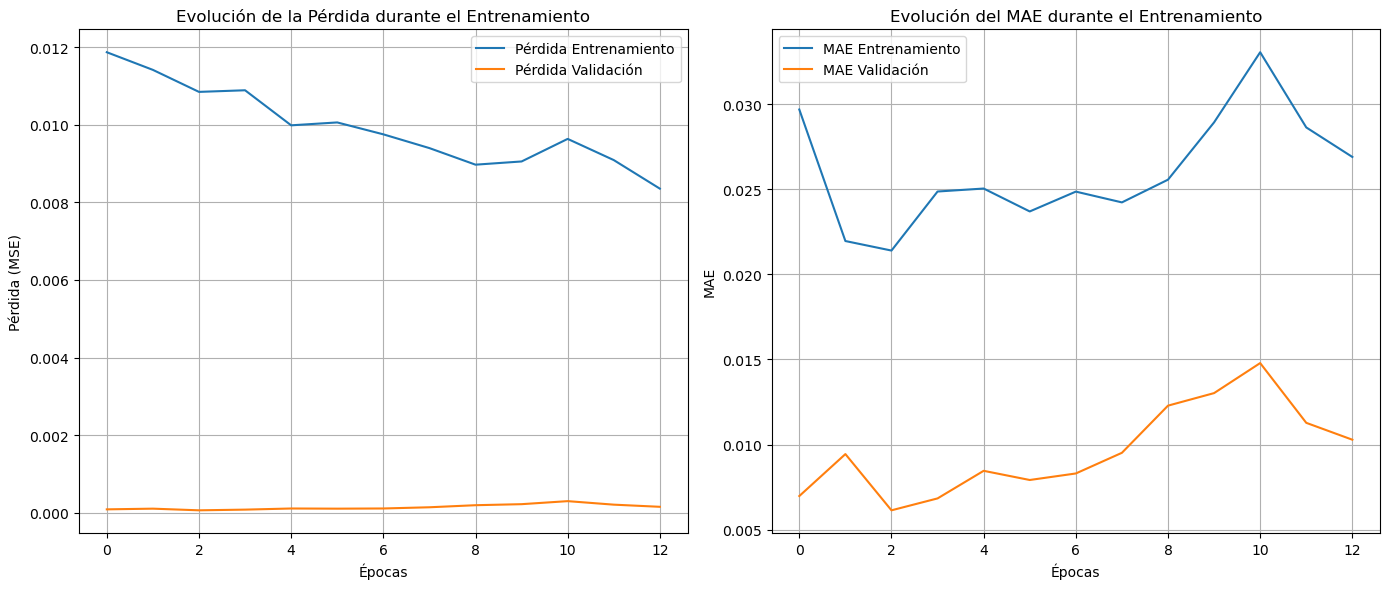

In [168]:
if 'history' in locals():

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Pérdida Entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida Validación')
    plt.title('Evolución de la Pérdida durante el Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida (MSE)')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='MAE Entrenamiento')
    plt.plot(history.history['val_mae'], label='MAE Validación')
    plt.title('Evolución del MAE durante el Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
else:
    print("El objeto 'history' no está disponible en el entorno actual.")


In [169]:

loss, mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Loss (MSE): {loss}, MAE: {mae}")

last_sequence = X_test[-1]
last_sequence = np.expand_dims(last_sequence, axis=0)
prediccion_escalada = model.predict(last_sequence)
prediccion_original = scaler_y.inverse_transform(prediccion_escalada)
print(f"Predicción para el siguiente valor: {prediccion_original[0, 0]}")

y_pred = model.predict(X_test)
y_test_original = scaler_y.inverse_transform(y_test)
y_pred_original = scaler_y.inverse_transform(y_pred)

rmse = math.sqrt(mean_squared_error(y_test_original, y_pred_original))
mape = mean_absolute_percentage_error(y_test_original, y_pred_original) * 100
print(f"RMSE: {rmse}, MAPE: {mape}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3.0420e-04 - mae: 0.0153
Loss (MSE): 0.0003041958261746913, MAE: 0.015287389047443867
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Predicción para el siguiente valor: 25594.0703125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
RMSE: 21818.885791559722, MAPE: 30789.573099255962%


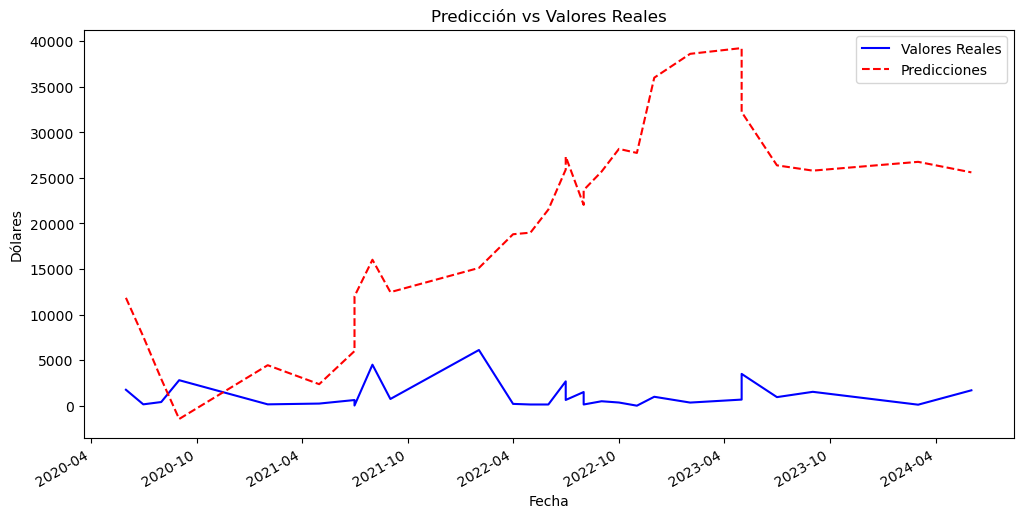

In [170]:
fechas_test = df['fecha'].iloc[-len(y_test_original):].reset_index(drop=True)
results_df = pd.DataFrame({
    'fecha': fechas_test,
    'valores_reales': y_test_original.flatten(),
    'predicciones': y_pred_original.flatten()
})

plt.figure(figsize=(12, 6))
plt.plot(results_df['fecha'], results_df['valores_reales'], label="Valores Reales", color="blue")
plt.plot(results_df['fecha'], results_df['predicciones'], label="Predicciones", color="red", linestyle="dashed")
plt.title("Predicción vs Valores Reales")
plt.xlabel("Fecha")
plt.ylabel("Dólares")
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gcf().autofmt_xdate()
plt.show()

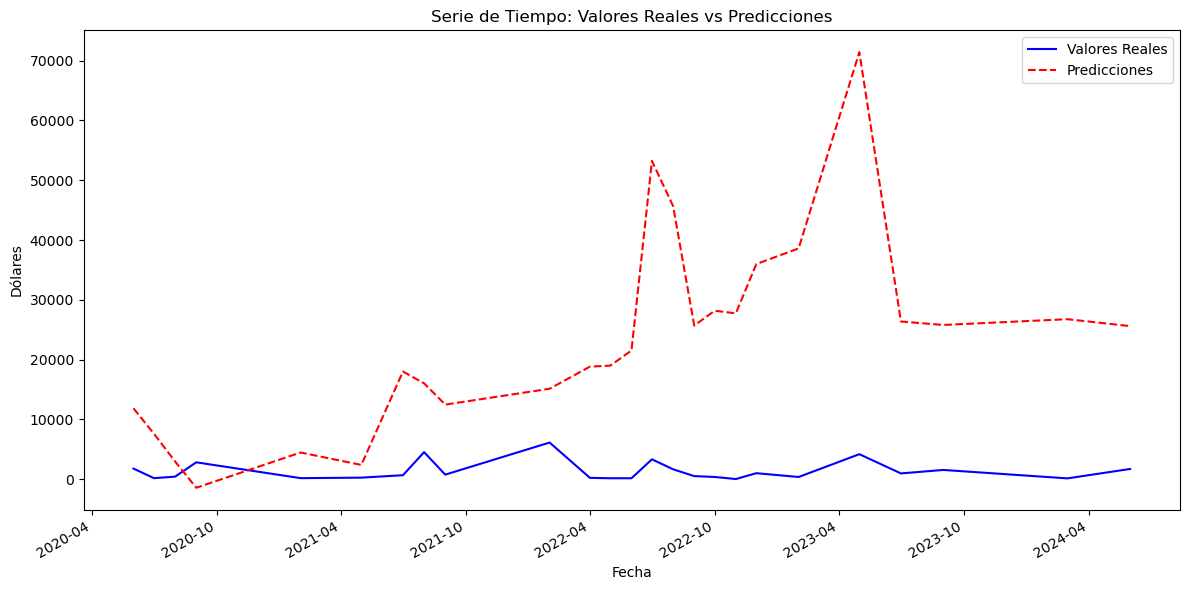

In [171]:
results_df['fecha'] = pd.to_datetime(results_df['fecha'])
aggregated_df = results_df.groupby('fecha').sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(aggregated_df['fecha'], aggregated_df['valores_reales'], label='Valores Reales', color='blue')
plt.plot(aggregated_df['fecha'], aggregated_df['predicciones'], label='Predicciones', color='red', linestyle='--')

plt.title('Serie de Tiempo: Valores Reales vs Predicciones')
plt.xlabel('Fecha')
plt.ylabel('Dólares')
plt.legend()

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()
